In [182]:
import torch
import scipy.io as sio
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt

import time

(-0.5, 63.5, 63.5, -0.5)

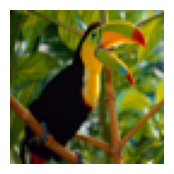

In [183]:
img = Image.open('img_002_SRF_2_LR.png')
img = img.resize((64,64),Image.BICUBIC)
img = np.asarray(img)
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')

In [184]:
y = torch.FloatTensor(np.asarray(img))

# Formulation

$$E(x,y,C)=||y-Cx||^2 + \gamma ||x||_1$$
We intend to find a sparse representation of $y$ in terms of $C$, we call this representation $x$. The first term is the reconstruction error, the second term is the sparsity penalty. $\gamma$ is a parameter that controls the trade-off between the two terms.

So far we have a few choices of solvers that solve this regularized problem, we will use the image provided above to illustrate different solvers.

# ISTA

In [185]:
def soft_thresholding(x, gamma):
    return torch.sign(x) * torch.max(torch.abs(x) - gamma, torch.zeros_like(x))

--- 0.00018739700317382812 seconds ---


Text(0.5, 0, 'iter')

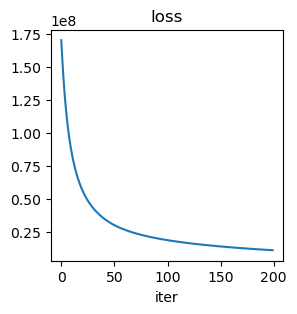

In [200]:
lr = 1e-3
max_iter = 200
gamma = 100
loss_list = []
c_recon = []
C = torch.randn(64, 50)
check_time = True
for c in range(3):
    yc = y[:,:,c]
    
    #x = torch.zeros(50, 64)
    #x = torch.randn(50, 64)
    x = C.t() @ yc
    # print(x.shape)
    for i in range(max_iter):
        if check_time:
            start_time = time.time()
        x = x + lr * C.t() @ (yc - C @ x)
        x = soft_thresholding(x, gamma*lr)
        if check_time:
            print("--- %s seconds ---" % (time.time() - start_time))
            check_time = False
        if c == 0:
            loss = torch.norm(yc - C @ x).item()+gamma * torch.norm(x,1).item()
            loss_list.append(loss)
    c_recon.append(x)
plt.figure(figsize=(3,3))
plt.plot(loss_list)
plt.title('loss')
plt.xlabel('iter')

20631.558642041564


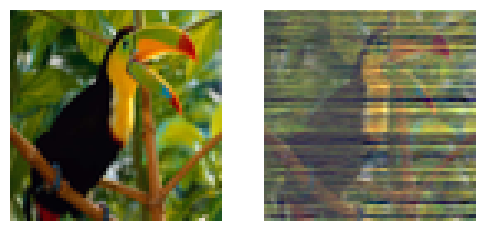

In [201]:
recons = []
for i in range(3):
    recons.append((C @ c_recon[i]).numpy())
recons = np.stack(recons, axis=2)

recons = (recons - np.min(recons)) / (np.max(recons) - np.min(recons)) * 255
recons = recons.astype(np.uint8)

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(recons)
ax[1].axis('off')

print(np.linalg.norm(img-recons))

the ratio of zero elements is 20.41%


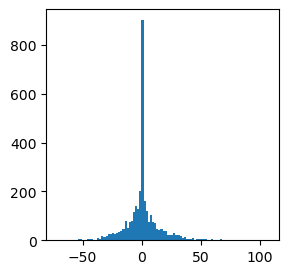

In [202]:
plt.figure(figsize=(3,3))
_ = plt.hist(x.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(x==0)/(x.shape[0]*x.shape[1]))*100:.2f}%")

# FISTA

--- 0.0002455711364746094 seconds ---
1


Text(0.5, 0, 'iter')

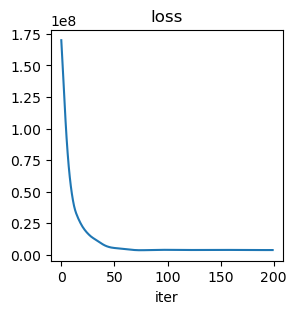

In [203]:
lr = 1e-3
max_iter = 200
gamma = 100
loss_list_FISTA = []
c_recon = []
# C = torch.randn(64, 50)
check_time = True
for c in range(3):
    yc = y[:,:,c]
    
    #x = torch.zeros(50, 64)
    #x = torch.randn(50, 64)
    z = C.t() @ yc
    # z = torch.zeros_like(z)
    x_1 = z
    L = 1
    tk = 1
    stop_linesearch = 0
    # print(x.shape)
    for i in range(max_iter):
        if check_time:
            start_time = time.time()
        gradient = C.t() @ (C @ z - yc)
        '''
        while not stop_linesearch:
            x = z - 1 / L * gradient
            x = soft_thresholding(x, gamma / L)
            energy = 0.5 * torch.norm(yc - C @ x).item()+gamma * torch.norm(x,1).item()
            upper_bound = 0.5 * torch.norm(yc - C @ z).item() + torch.sum(gradient * (x - z)) +\
                            0.5 * L * torch.norm(x - z).item() + gamma * torch.norm(z,1).item()
            stop_linesearch = energy <= upper_bound
            L = L * 2
        '''
        x = z - lr * gradient
        x = soft_thresholding(x, gamma * lr)
        # print(L)
        tk_1 = (1+(1+4 * tk**2)**0.5)/2
        z = x + (tk - 1) / tk_1 * (x - x_1)
        x_1 = x
        tk = tk_1
        if check_time:
            print("--- %s seconds ---" % (time.time() - start_time))
            check_time = False
        if c == 0:
            loss = torch.norm(yc - C @ x).item()+gamma * torch.norm(x,1).item()
            loss_list_FISTA.append(loss)
    c_recon.append(x)
    
print(L)
plt.figure(figsize=(3,3))
plt.plot(loss_list_FISTA)
plt.title('loss')
plt.xlabel('iter')

Text(0.5, 0, 'iter')

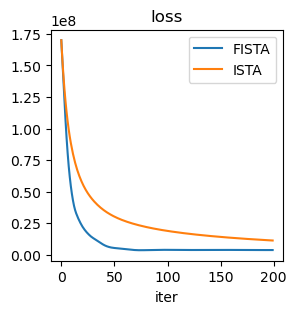

In [204]:
plt.figure(figsize=(3,3))
plt.plot(loss_list_FISTA, label='FISTA')
plt.plot(loss_list, label='ISTA')
plt.legend()
plt.title('loss comparison')
plt.title('loss')
plt.xlabel('iter')

19992.890836494855


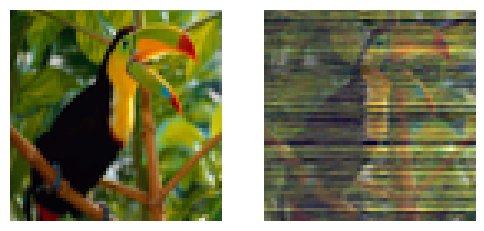

In [197]:
recons = []
for i in range(3):
    recons.append((C @ c_recon[i]).numpy())
recons = np.stack(recons, axis=2)

recons = (recons - np.min(recons)) / (np.max(recons) - np.min(recons)) * 255
recons = recons.astype(np.uint8)

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(recons)
ax[1].axis('off')

print(np.linalg.norm(img-recons))

the ratio of zero elements is 41.44%


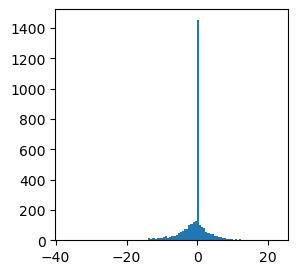

In [198]:
plt.figure(figsize=(3,3))
_ = plt.hist(x.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(x==0)/(x.shape[0]*x.shape[1]))*100:.2f}%")

# Shrinkage

--- 0.937779426574707 seconds ---


Text(0.5, 0, 'iter')

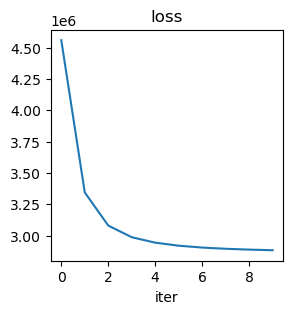

In [193]:
max_iter = 10
loss_list = []
c_recon = []
# C = torch.randn(64, 50)
mu = 100
m,n = C.shape
C_hat = torch.zeros((m*m,m*n))
check_time = True
for i in range(m):
    for j in range(n):
        C_hat[i*m:(i+1)*m,j*m:(j+1)*m] = C[i,j] * torch.eye(m)


for c in range(3):
    yc = y[:,:,c]
    Cy = (C.t() @ yc).flatten()
    x = C.t() @ yc
    x_hat = x.flatten()
    for i in range(max_iter):
        if check_time:
            start_time = time.time()
        #W_inv = torch.diag(torch.abs(x_hat)/ mu)
        #x_hat = W_inv @ Cy - W_inv @ C_hat.t() @ \
        #torch.inverse(torch.eye(m*m)+C_hat @ W_inv @ C_hat.t()) @ (C_hat @ W_inv @ Cy)
        W_inv = torch.abs(x_hat)/ mu
        x_hat = W_inv * Cy - (W_inv * C_hat).t() @ \
            torch.inverse(torch.eye(m*m)+(C_hat * W_inv) @ C_hat.t()) @ ((C_hat * W_inv) @ Cy)
        if check_time:
            print("--- %s seconds ---" % (time.time() - start_time))
            check_time = False
        if (i+1)%100 == 0:
            print(f'iter {i+1}')
        if c == 0:
            loss = torch.norm(yc - C @ x_hat.reshape(n,m)).item()+gamma * torch.norm(x_hat,1).item()
            loss_list.append(loss)
    c_recon.append(x_hat.reshape((n,m)))
plt.figure(figsize=(3,3))
plt.plot(loss_list)
plt.title('loss')
plt.xlabel('iter')

19961.334248992476


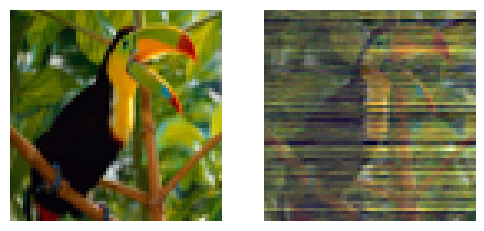

In [194]:
recons = []
for i in range(3):
    recons.append((C @ c_recon[i]).numpy())
recons = np.stack(recons, axis=2)

recons = (recons - np.min(recons)) / (np.max(recons) - np.min(recons)) * 255
recons = recons.astype(np.uint8)

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(recons)
ax[1].axis('off')

print(np.linalg.norm(img-recons))

the ratio of zero elements is 12.34%


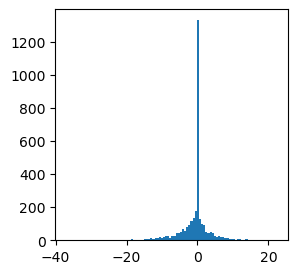

In [199]:
plt.figure(figsize=(3,3))
_ = plt.hist(x_hat.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(x_hat)<1e-5)/(x_hat.shape[0]))*100:.2f}%")

# Shrinkage Uing Small Patches

In [33]:
def split_image(img, patch_size):
    h, w, c = img.shape
    h_num = h // patch_size
    w_num = w // patch_size
    patches = []
    for i in range(h_num):
        for j in range(w_num):
            patch = img[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size,:]
            patches.append(patch)
    return patches

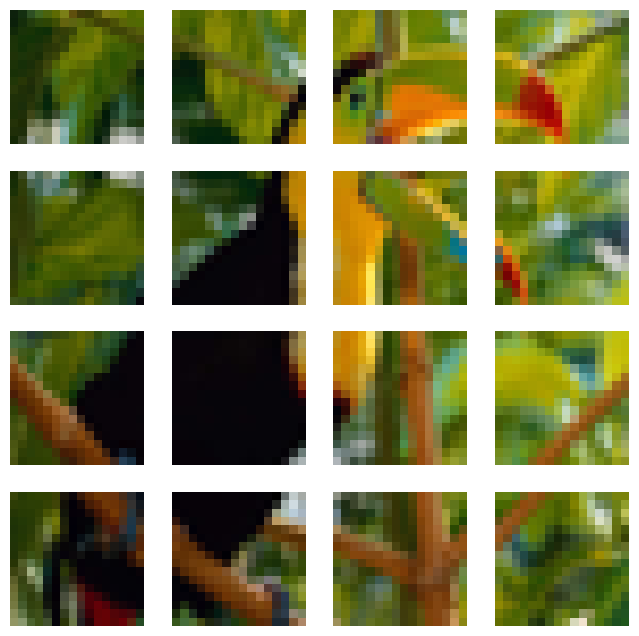

In [34]:
patch_size = 16
n_patches = 64 // patch_size
patches = split_image(y, patch_size)
fig, ax = plt.subplots(n_patches, n_patches, figsize=(8,8))

for i in range(n_patches):
    for j in range(n_patches):
        ax[i,j].imshow(patches[i*n_patches+j].numpy().astype(np.uint8))
        ax[i,j].axis('off')


tensor(5.5982)
--- 0.023193359375 seconds ---
14927.330069372754


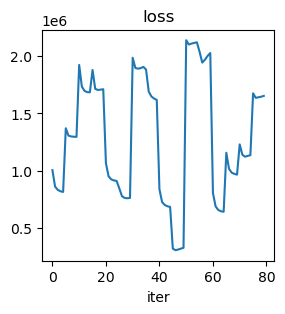

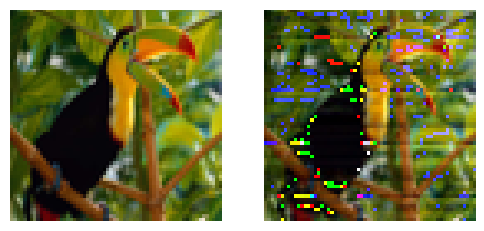

In [232]:
C = torch.randn(patch_size,patch_size)
# C = C / torch.norm(C, dim=0)
max_iter = 5
loss_list = []
c_recon = []
# C = torch.randn(64, 50)
#C = torch.randn(patch_size,patch_size)
w = torch.rand(16,16)
mu = torch.abs(C @ w).max()#20
print(mu)
m,n = C.shape
C_hat = torch.zeros((m*m,m*n))
check_time = True
for i in range(m):
    for j in range(n):
        C_hat[i*m:(i+1)*m,j*m:(j+1)*m] = C[i,j] * torch.eye(m)
    
for patch in patches:
    for c in range(3):
        yc = patch[:,:,c]
        Cy = (C.t() @ yc).flatten()
        x = C.t() @ yc
        x_hat = x.flatten()
        for i in range(max_iter):
            if check_time:
                start_time = time.time()
            
            #W_inv = torch.diag(torch.abs(x_hat)/ mu)
            #x_hat = W_inv @ Cy - W_inv @ C_hat.t() @ \
            #    torch.inverse(torch.eye(m*m)+C_hat @ W_inv @ C_hat.t()) @ (C_hat @ W_inv @ Cy)
            
            W_inv = torch.abs(x_hat)/ mu
            x_hat = W_inv * Cy - (W_inv * C_hat).t() @ \
                torch.inverse(torch.eye(m*m)+(C_hat * W_inv) @ C_hat.t()) @ ((C_hat * W_inv) @ Cy)
            
            if check_time:
                print("--- %s seconds ---" % ((time.time() - start_time)*16))
                check_time = False
            if (i+1)%100 == 0:
                print(f'iter {i+1}')
            if c == 0:
                loss = torch.norm(yc - C @ x_hat.reshape(n,m)).item()+gamma * torch.norm(x_hat,1).item()
                loss_list.append(loss)
                #if i > 0 and loss_list[-1] > loss_list[-2]:
                #    break
                
        x_index = x_hat / torch.norm(x_hat)
        x_index = torch.abs(x_index) < 1e-3
        x_hat[x_index] = 0
        c_recon.append(x_hat.reshape((n,m)))
        
plt.figure(figsize=(3,3))
plt.plot(loss_list)
plt.title('loss')
plt.xlabel('iter')


recons = []

for i in range(len(c_recon)):
    recons.append((C @ c_recon[i]).numpy())
    
recon_img = np.zeros((64,64,3))

#for i in range(len(recons)):
#    recon_img[i//8*8:(i//8+1)*8,i%8*8:(i%8+1)*8,i%3] = recons[i]
    
for i in range(len(recons) // 3):
    r = i // n_patches
    c = i % n_patches
    for j in range(3):
        recon_img[r*patch_size:(r+1)*patch_size,c*patch_size:(c+1)*patch_size,j] = recons[i*3+j]
        #recon_img[i*8:(i+1)*8,j*8:(j+1)*8,j] = recons[i*3+j]
        
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(recon_img.astype(np.uint8))
ax[1].axis('off')

print(np.linalg.norm(img-recon_img.astype(np.uint8)))

the ratio of zero elements is 16.02%


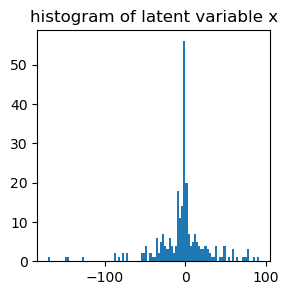

In [178]:
plt.figure(figsize=(3,3))
plt.title("histogram of latent variable x")
_ = plt.hist(x_hat.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(x_hat)<=1e-5)/(x_hat.shape[0]))*100:.2f}%")

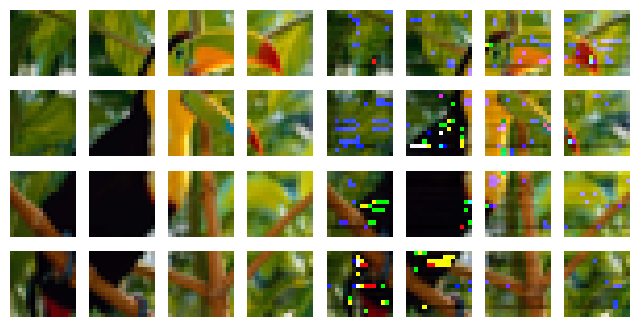

In [240]:
patch_size = 16
n_patches = 64 // patch_size
patches_recon = split_image(recon_img, patch_size)
fig, ax = plt.subplots(n_patches, 2 * n_patches, figsize=(8,4))

for i in range(n_patches):
    for j in range(n_patches):
        ax[i,j].imshow(patches[i*n_patches+j].numpy().astype(np.uint8))
        ax[i,j].axis('off')
        ax[i,n_patches+j].imshow(patches_recon[i*n_patches+j].astype(np.uint8))
        ax[i,n_patches+j].axis('off')


| Methods          |      Iterations to Converge      |  Reconstruction Error | Dictionary Size | Computational Time (s) | sparsity |
|:----------------:|    :-----------------------:     | :-------------------: | :-------------: | :----------------: | :------: |
| ISTA             |          500                    |     21066             |     3200        | 6e-4 | 39.38% |
| Shrinkage        |    10                      |     20558             |     3200        | 1.12 | 12.78% |
| Shrinkage-Patch (16x16)  | 10                    |     15653             |     256         | 4.24e-2 |  7.3%  |

# What to do next?
1. Implement original DPCN + OpenSource
    * Improve by using different initialization instead of 0 vectors for $x$ and $u$
    * Add topdown information
    * Convolutional DPCN (This may not apply to Shrinkage algorithm)
2. Try different sparsification algorithms with DPCN
    * FISTA ($L_1$)
    * Shrinkage ($L_1$)
    * Shrinkage using small patches ($L_1$)
    * Orthogonal Matching Pursuit (OMP) ($L_0$)
    * Iterative Hard Thresholding (IHT) ($L_0$)
    * Correntropy??? ($L_0$)
3. Try different dataset
    * Geometric Toy Video Dataset ✅
    * CIFAR-10 ✅
    * Mario Video Dataset
    * Human Face Video Dataset
4. Convolutional sparse coding (Hongming)
    * Comparerison experiments with other methods ![](https://geps.dev/progress/10)